# Content

The content in this notebook follows ISLR Chapter 8 and includes the following topics:

* Introduction to Tree Based Methods
* Regression Trees
* Regression Tree Examples
* Classification Trees
* `carseats` data for Classification Trees
* Bagging
* Random Forests
* Boosting

Tree based methods and ensembles are very good for feature selection and prediction, but lacking on model interpretability (not as robust as regression). More advanced ensemble techniques like Random Forests are the closest thing to a neural network API.

In [2]:
# install.packages('rpart.plot')

In [3]:
# install.packages('ggthemes')

In [96]:
library(ISLR)
library(tree)
library(rpart)
library(rpart.plot)
library(corrplot)
library(randomForest)
library(boot)
library(ROCR)
library(caret)
library(data.table)
library(dplyr)
library(ggthemes)
library(ggplot2)

data(Hitters)
data(Carseats)

## Decision Trees

Decision trees segment the predictor search space into smaller regions based on the independent variables.

Typically the independent variable to split on is found by optimizing a measure of information gain like *entropy* or *gini index*. The splitting process continues until an optional max depth is reached or when the node contains only one unique label.

When making a prediction for a particular data point, find the region that the data point belongs to and take the appropriate statistic of the data in that space. The statistic should be determined by the business problem context.

The rules determined by the model resemble a tree so they are called decision trees. We can use them for classification and regression problems, so sometimes the model is referred to as ***Classification and Regression Trees (CART)*** methods.

Set of features $X_{1},X_{2},\ldots , X_{p}$, want to predict response $Y$ which could be quantitative or categorical:

1. Grow a binary tree - each internal node has two branches
2. At each internal node of tree, apply a test to one of the predictors $X_{i}$
3. Assume the test to be $X_{i} < t$
    * If test is true, go to the left branch
    * If test is false, go to the right branch
4. Eventually we come to a ***terminal or leaf node*** and make a prediction

## Regression Trees 

* We'll use `Hitters` dataset in the `ISLR` package
* Predict a baseball player's Salary based on
    * Years
    * Hits

We'll also perform the following transformations to the dataset before building our model:

* Drop rows without a target variable (Salary)
* Log-transform Salary (make it more Normal)

In [5]:
df <- cbind(Hitters)

In [6]:
head(df)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NA,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [7]:
str(df)

'data.frame':	322 obs. of  20 variables:
 $ AtBat    : int  293 315 479 496 321 594 185 298 323 401 ...
 $ Hits     : int  66 81 130 141 87 169 37 73 81 92 ...
 $ HmRun    : int  1 7 18 20 10 4 1 0 6 17 ...
 $ Runs     : int  30 24 66 65 39 74 23 24 26 49 ...
 $ RBI      : int  29 38 72 78 42 51 8 24 32 66 ...
 $ Walks    : int  14 39 76 37 30 35 21 7 8 65 ...
 $ Years    : int  1 14 3 11 2 11 2 3 2 13 ...
 $ CAtBat   : int  293 3449 1624 5628 396 4408 214 509 341 5206 ...
 $ CHits    : int  66 835 457 1575 101 1133 42 108 86 1332 ...
 $ CHmRun   : int  1 69 63 225 12 19 1 0 6 253 ...
 $ CRuns    : int  30 321 224 828 48 501 30 41 32 784 ...
 $ CRBI     : int  29 414 266 838 46 336 9 37 34 890 ...
 $ CWalks   : int  14 375 263 354 33 194 24 12 8 866 ...
 $ League   : Factor w/ 2 levels "A","N": 1 2 1 2 2 1 2 1 2 1 ...
 $ Division : Factor w/ 2 levels "E","W": 1 2 2 1 1 2 1 2 2 1 ...
 $ PutOuts  : int  446 632 880 200 805 282 76 121 143 0 ...
 $ Assists  : int  33 43 82 11 40 421 127 28

# Drop rows with no target variable

In this context, it is probably best to drop all rows having no target variable present.

In [8]:
df_salary_present <- subset(df, !is.na(Salary))
str(df_salary_present)

'data.frame':	263 obs. of  20 variables:
 $ AtBat    : int  315 479 496 321 594 185 298 323 401 574 ...
 $ Hits     : int  81 130 141 87 169 37 73 81 92 159 ...
 $ HmRun    : int  7 18 20 10 4 1 0 6 17 21 ...
 $ Runs     : int  24 66 65 39 74 23 24 26 49 107 ...
 $ RBI      : int  38 72 78 42 51 8 24 32 66 75 ...
 $ Walks    : int  39 76 37 30 35 21 7 8 65 59 ...
 $ Years    : int  14 3 11 2 11 2 3 2 13 10 ...
 $ CAtBat   : int  3449 1624 5628 396 4408 214 509 341 5206 4631 ...
 $ CHits    : int  835 457 1575 101 1133 42 108 86 1332 1300 ...
 $ CHmRun   : int  69 63 225 12 19 1 0 6 253 90 ...
 $ CRuns    : int  321 224 828 48 501 30 41 32 784 702 ...
 $ CRBI     : int  414 266 838 46 336 9 37 34 890 504 ...
 $ CWalks   : int  375 263 354 33 194 24 12 8 866 488 ...
 $ League   : Factor w/ 2 levels "A","N": 2 1 2 2 1 2 1 2 1 1 ...
 $ Division : Factor w/ 2 levels "E","W": 2 2 1 1 2 1 2 2 1 1 ...
 $ PutOuts  : int  632 880 200 805 282 76 121 143 0 238 ...
 $ Assists  : int  43 82 11 40 42

### Check Correlation Plot

As a habit, I always like to check the correlation plot before continuing with a regression task.

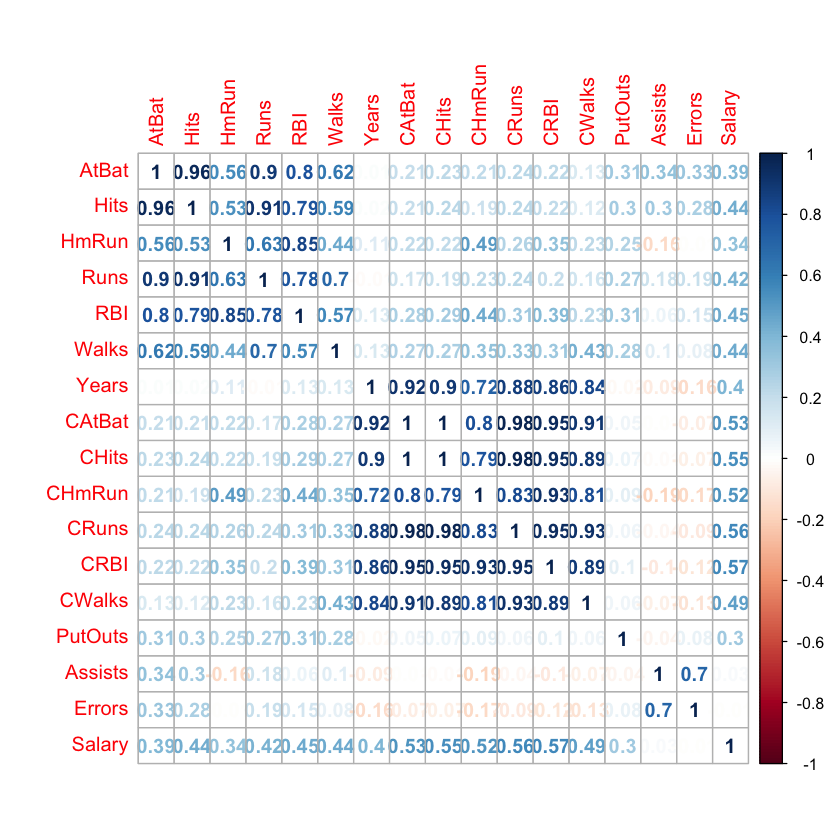

In [9]:
# Grab only numeric columns
numeric_columns <- sapply(df_salary_present, is.numeric)
# Filter to numeric columns for correlation
data_for_corr_plot <- cor(df_salary_present[,numeric_columns])
corrplot(data_for_corr_plot,method='number')

# Applying our log transformation

The Barry Bonds of the world skew our target variable, so it's probably best to apply a log-transformation to `Salary`. Let's check the correlation plot again for changes.

In [10]:
df_salary_present$log_Salary<- log(df_salary_present$Salary)

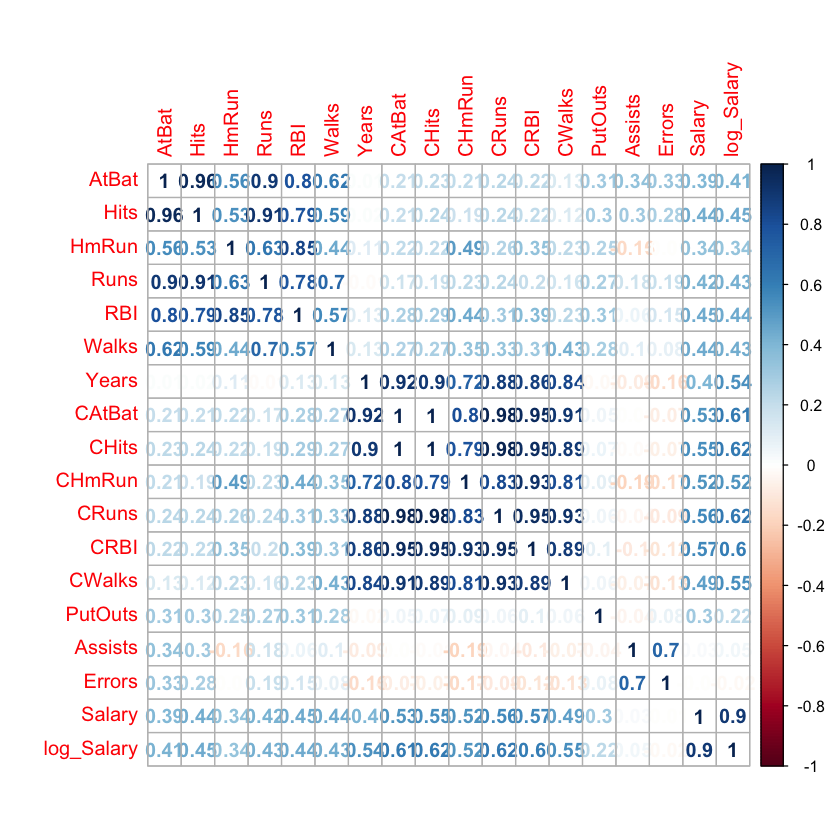

In [11]:
# Grab only numeric columns
numeric_columns <- sapply(df_salary_present, is.numeric)
# Filter to numeric columns for correlation
data_for_corr_plot <- cor(df_salary_present[,numeric_columns])
corrplot(data_for_corr_plot,method='number')

When considering the log transformed variable `log_Salary` as our target, we can see that some of the linear relationships between our features and target variable have improved. This is a really nice finding as a log transformation has little effect on model interpretability.

In [12]:
tree_regression_salary_using_years_and_hits <- rpart(log_Salary~Years+Hits, df_salary_present, method = 'anova')
tree_regression_salary_using_years_and_hits

n= 263 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 263 207.153700 5.927222  
   2) Years< 4.5 90  42.353170 5.106790  
     4) Years< 3.5 62  23.008670 4.891812  
       8) Hits< 114 43  17.145680 4.727386 *
       9) Hits>=114 19   2.069451 5.263932 *
     5) Years>=3.5 28  10.134390 5.582812 *
   3) Years>=4.5 173  72.705310 6.354036  
     6) Hits< 117.5 90  28.093710 5.998380  
      12) Years< 6.5 26   7.237690 5.688925 *
      13) Years>=6.5 64  17.354710 6.124096  
        26) Hits< 50.5 12   2.689439 5.730017 *
        27) Hits>=50.5 52  12.371640 6.215037 *
     7) Hits>=117.5 83  20.883070 6.739687 *

cex 0.866   xlim c(0, 1)   ylim c(-0.1, 1.1)


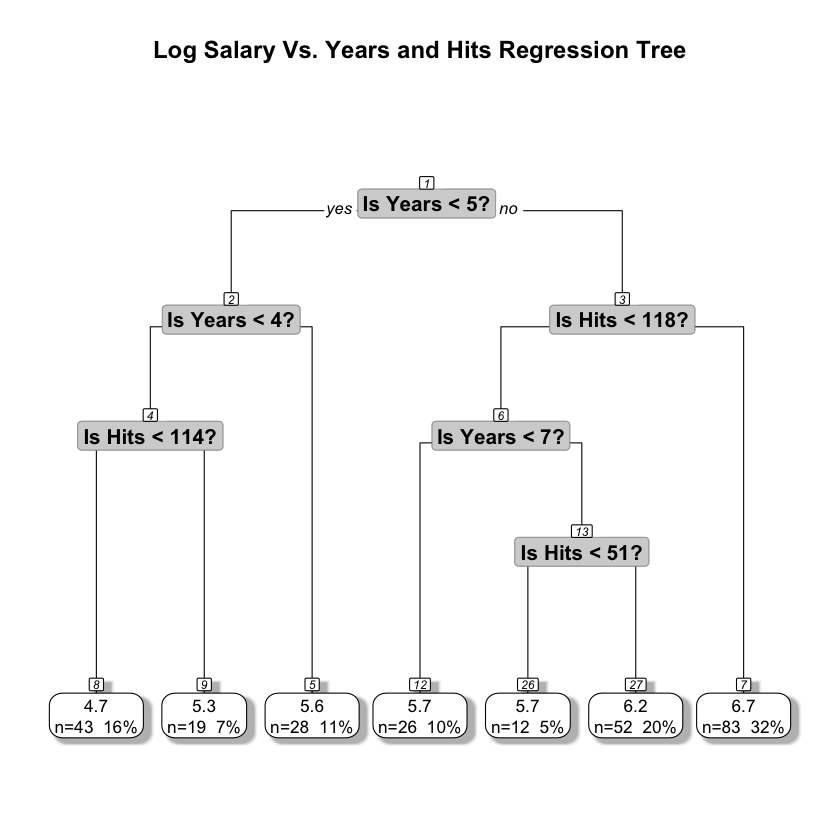

In [13]:
prp(tree_regression_salary_using_years_and_hits, main="Log Salary Vs. Years and Hits Regression Tree",
extra=101, # display crime rate and percent of obs
nn=TRUE, # display the node numbers
fallen.leaves=TRUE, # put the leaves on the bottom of the page
shadow.col="gray", # shadows under the leaves
faclen=0, # faclen=0 to print full factor names
trace=1, # print the automatically calculated cex
split.cex=1.2, # make the split text larger than the node text
split.prefix="Is ", # put "is " before split text
split.suffix="?", # put "?" after split text
split.box.col="lightgray", # lightgray split boxes (default is white)
split.border.col="darkgray", # darkgray border on split boxes
split.round=.5) # round the split box corners a tad

Regions $8, 9, 5, 12, 26, 27, 7$ are known as ***terminal nodes or leaves*** of the tree.

Regions $1, 2, 3, 4, 6, 13$ are known as ***internal nodes*** and refer to points in the tree where the predictor space is split.

Segments of trees that connect nodes are called ***branches***.

We can interpret the splits as follows:
* `Years` is the most important predictor since it is the first feature to be split on (top of the tree)
* For a more experienced player (Y > Years=5), number of hits the previous year seems to be the driving factor behind salary since it is the only internal node appearing after root.

Note that our leaves are still log-transformed and will need to be converted back to an appropriate unit like thousands USD:

$$
e^{5.3} = \$ 200.34 \text{k}
$$

## Decision Tree Partitioning

At it's core, a decision tree is partitioning the solution space until each leave contains a single label. Despite it's simplicity, the method is very effective. The figure taken from ISLR below visualizes exactly what the tree is doing.

<img src="images/dtree-partition.png">

All of this begs the question, *how exactly are the partitions determined?*

### Constructing Regions

* In theory, regions could have any shape
* For simplicity and for model interpretability, we decide to only partition the predictor space using high-dimensional rectangles or boxes.
* Goal is to find boxes $R_{1}, \ldots , R_{J}$ that minimize the Sum of Squared Errors (SSE):

$$
\sum^{J}_{j=1}\sum_{i\,\varepsilon\, R_{j}} \left(y_{i} - \hat{y}_{R_{j}}\right)^{2}
$$

where $\hat{y}_{R_{j}}$ is the mean response for the training observations within the $j$th box

### Top-Down Greedy Approach

* Computationally infeasible to consider every possible partition of feature space into J boxes
* Hence, we take top-down, greedy approach called **recursive binary splitting**
    * Begins at top of tree with all observations in single region, then successively splits the predictor space
    * Every split has two new branches further down tree
    * Greedy algorithm because each split is made at that particular step rather than looking ahead and picking the best global split

### Recursive Binary Splitting

The recursive binary splitting algorithm is detailed below:

1. Select predictor $X_{j}$ and the cutpoint $s$ such that splitting the predictor space into the regions $\left\{X_{j} \: | \: X_{j} < s\right\}$ and $\left\{X_{j} \: | \:  X_{j} >= s\right\}$ leads to the greatest possible reduction in SSE

2. We must consider all predictors $X_{1}, X_{2}, \ldots , X_{p}$ and all possible values of $s$ for each of the predictors, and then choose the predictor and its cutpoint such that the resulting tree has the lowest SSE. This means that for any $j$ and $s$, we define the pair of half-planes $R_{1}\left(j,s\right)=\left\{X_{j} \: | \: X_{j} < s\right\}$ and $R_{2}\left(j,s\right)=\left\{X_{j} \: | \:  X_{j} >= s\right\}$, and we seek the value of $j$ and $s$ that minimizes the equation:

$$
\sum_{i \, ; \, x_{i} \, \varepsilon \, R_{1}\left(j,s\right)} \left(y_{i} - \hat{y}_{R_{1}}\right)^{2} + \sum_{i \, ; \, x_{i} \, \varepsilon \, R_{2}\left(j,s\right)} \left(y_{i} - \hat{y}_{R_{2}}\right)^{2}
$$

* where $\hat{y}_{R_{1}}$ is the mean response for training observations in $R_{1}\left(j,s\right)$
* where $\hat{y}_{R_{2}}$ is the mean response for training observations in $R_{2}\left(j,s\right)$

Finding the optimal values of $j$ and $s$ that minimize the equation can be done quickly, especially if $p$ is not too large.

We continue this process recursively looking for the best predictor and cutpoint to split the data further so as to minimze the SSE within each of the split regions.

Note, if we start with one region and split we will have two regions. If we take one of these two regions and split it again, we will then have three regions, etc, etc.

The process continues until a user specified stopping criterion has been reached. For example:
* Continue splitting until no terminal region contains more than $x$ number of observations
* Max_Depth or the maximum number of levels is reached

Once the regions $R_{1}, \ldots , R_{J}$ have been created, we predict the response for a given test observation using the means of the training observation in the region that in which that test observation belongs.

### Tree Pruning

* Recursive binary splitting may produce good predictions on the training set but is likely to overfit the data (decision tree is too complex!), leading to poor performance on the test set.

* A smaller tree with fewer splits (i.e., fewer regions $R_{1}, \ldots , R_{J}$) might lead to
    * Lower variance
    * Better interpretation at cost of a little bias

* One alternative is to build a tree as long as the decrease in SSE due to each split exceeds a (high) threshold
    * This will result in smaller trees but could be short-sighted since an initial seemingly-worthless split might be followed by a very good split later on.
    
### Tree Pruning Strategies

A better strategy is to grow a very large tree (which we'll call $T_{0}$) and then prune back to obtain a subtree.

How do we find the best subtree?
* Performance is always determined using the solution that provides the lowest test error rate
* Given a subtree, we can estimate the test error rate by using a hold out test dataset or by using cross-validation (CV)

However, it becomes computationally infeasible to estimate the CV for every possible subtree since there are so many subtrees. We need a way to select a small set of subtrees to consider.

### Cost Complexity Pruning

**Cost complexity pruning** or **weakest link pruning** is a way to select a small set of subtrees to consider.

Instead of examining every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$.

* $\left|T\right|$ indicates the number of terminal nodes of a tree $T$
* $R_{m}$ is the rectangle or box corresponding to the $m$th terminal node
* $\hat{y}_{R_{m}}$ is the mean response for the training observations within the $m$th box
* $\alpha$ controls trade-off between subtree's complexity and its fit to the training data and for each value of $\alpha$ there is a subtree $T \, \varepsilon \, T_{0}$, such that

$$
\text{Equation }8.4 \: \: \: \sum^{\left|T\right|}_{m=1} \sum_{x_{i} \, \varepsilon \, R_{m}} \left(y_{i} - \hat{y}_{R_{m}}\right)^{2} + \alpha\left|T\right|
$$

is as small as possible.

* When $\alpha=0$, the subtree $T$ will simply be equal to $T_{0}$, because $\text{Equation }8.4$ measures the training error
* As $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes and so $\text{Equation }8.4$ will be minimized when we have a smaller tree
* $\text{Equation }8.4$ is similar to LASSO Regression, which can be used to control the complexity of a linear model
* As we increase $\alpha$ from 0 in $\text{Equation }8.4$, branches get pruned from tree in nested/predictable manner, which means obtaining the whole sequence of subtrees as a function of $\alpha$ is easy

## Regression Tree Output

We can call the familiar `summary` function on our trained regression tree object to see further model details, including the number of terminal nodes and the "deviance" or SSE.

In [14]:
summary(tree_regression_salary_using_years_and_hits)

Call:
rpart(formula = log_Salary ~ Years + Hits, data = df_salary_present, 
    method = "anova")
  n= 263 

          CP nsplit rel error    xerror       xstd
1 0.44457445      0 1.0000000 1.0143686 0.06608065
2 0.11454550      1 0.5554255 0.5639534 0.05889559
3 0.04446021      2 0.4408800 0.4626496 0.05716566
4 0.01831268      3 0.3964198 0.4179324 0.05827673
5 0.01690198      4 0.3781072 0.4162701 0.06402744
6 0.01107214      5 0.3612052 0.4132046 0.06449742
7 0.01000000      6 0.3501330 0.4359614 0.06568704

Variable importance
Years  Hits 
   76    24 

Node number 1: 263 observations,    complexity param=0.4445745
  mean=5.927222, MSE=0.7876568 
  left son=2 (90 obs) right son=3 (173 obs)
  Primary splits:
      Years < 4.5   to the left,  improve=0.4445745, (0 missing)
      Hits  < 117.5 to the left,  improve=0.2229369, (0 missing)
  Surrogate splits:
      Hits < 29.5  to the left,  agree=0.669, adj=0.033, (0 split)

Node number 2: 90 observations,    complexity param=0.044460

## Example 2: `MASS::Boston`

Now we'll go through the `Boston` housing dataset and build another regresion tree.

In [97]:
library(MASS)
data(Boston)

help(Boston)

### Split Data 50/50 and Train Model

We'll quickly build a 50/50 regression tree model using the `sample`, `nrow` and the `rpart` functions.

In [16]:
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston)/2)
tree2 <- rpart(medv~., Boston, subset=train)
tree2_ <- tree(medv~., Boston, subset=train)

### Plot Tree

Let's visualize the final regression tree using the helper function `prp`.

cex 0.788   xlim c(0, 1)   ylim c(-0.05, 1.05)


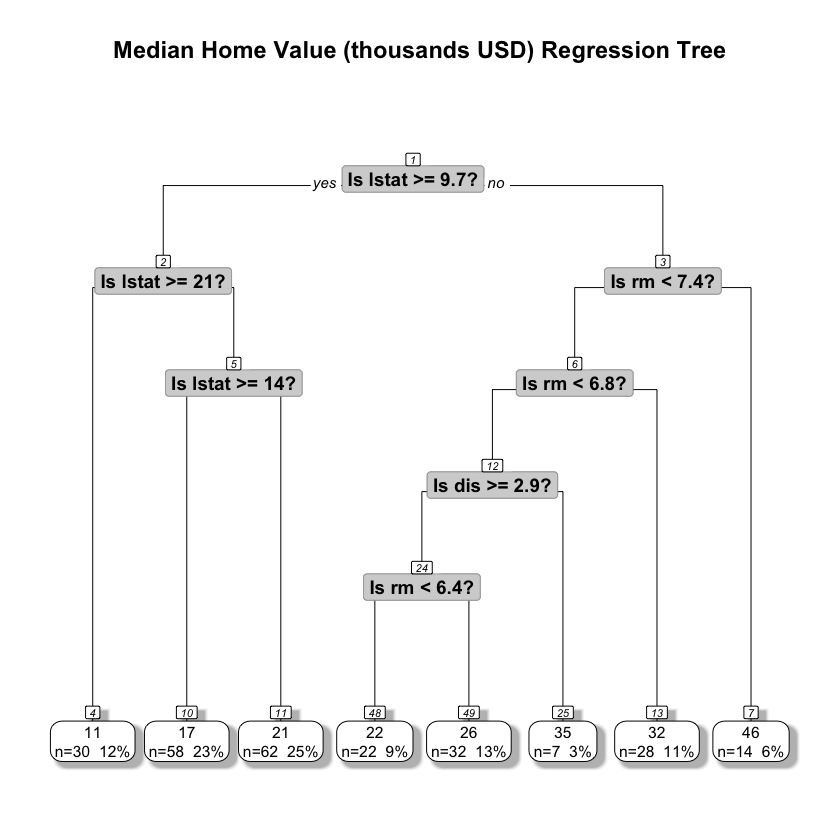

In [17]:
prp(tree2, main="Median Home Value (thousands USD) Regression Tree",
extra=101,
nn=TRUE, # display the node numbers
fallen.leaves=TRUE, # put the leaves on the bottom of the page
shadow.col="gray", # shadows under the leaves
faclen=0, # faclen=0 to print full factor names
trace=1, # print the automatically calculated cex
split.cex=1.2, # make the split text larger than the node text
split.prefix="Is ", # put "is " before split text
split.suffix="?", # put "?" after split text
split.box.col="lightgray", # lightgray split boxes (default is white)
split.border.col="darkgray", # darkgray border on split boxes
split.round=.5) # round the split box corners a tad

We can see from the tree above that the root split feature `lstat` or *the lower status of the population (expressed in %)* is the most important predictor for the median value of owner occupied homes (expressed in $'000s).

Other important factors include `rm` or *average number of rooms per dwelling* and `dis` or *weighted mean of distances to five Boston employment centers*

### Model Diagnostics

Next, lets call `summary` on the `rpart` function to get the diagnostics of model fit.

In [18]:
summary(tree2)

Call:
rpart(formula = medv ~ ., data = Boston, subset = train)
  n= 253 

          CP nsplit rel error    xerror       xstd
1 0.46257558      0 1.0000000 1.0127304 0.11772795
2 0.20467339      1 0.5374244 0.5633934 0.05969933
3 0.07461842      2 0.3327510 0.3494856 0.03994467
4 0.03919129      3 0.2581326 0.2960757 0.03997597
5 0.03208187      4 0.2189413 0.3107221 0.04807582
6 0.02162884      5 0.1868595 0.2950782 0.04805304
7 0.01114973      6 0.1652306 0.2614557 0.04260435
8 0.01000000      7 0.1540809 0.2503241 0.03701355

Variable importance
  lstat      rm   indus     nox    crim      zn     dis     age ptratio     rad 
     28      23      12      12      11       9       3       2       1       1 

Node number 1: 253 observations,    complexity param=0.4625756
  mean=22.67312, MSE=82.58758 
  left son=2 (150 obs) right son=3 (103 obs)
  Primary splits:
      lstat   < 9.715    to the right, improve=0.4625756, (0 missing)
      rm      < 6.803    to the left,  improve=0.4235645

## Regression Tree Cross Validation (CV)

Next, let's see if the results generated on our 50/50 split generalize by measuring the cross validation accuracy. From here we can see if we'll need to prune the tree later or not.

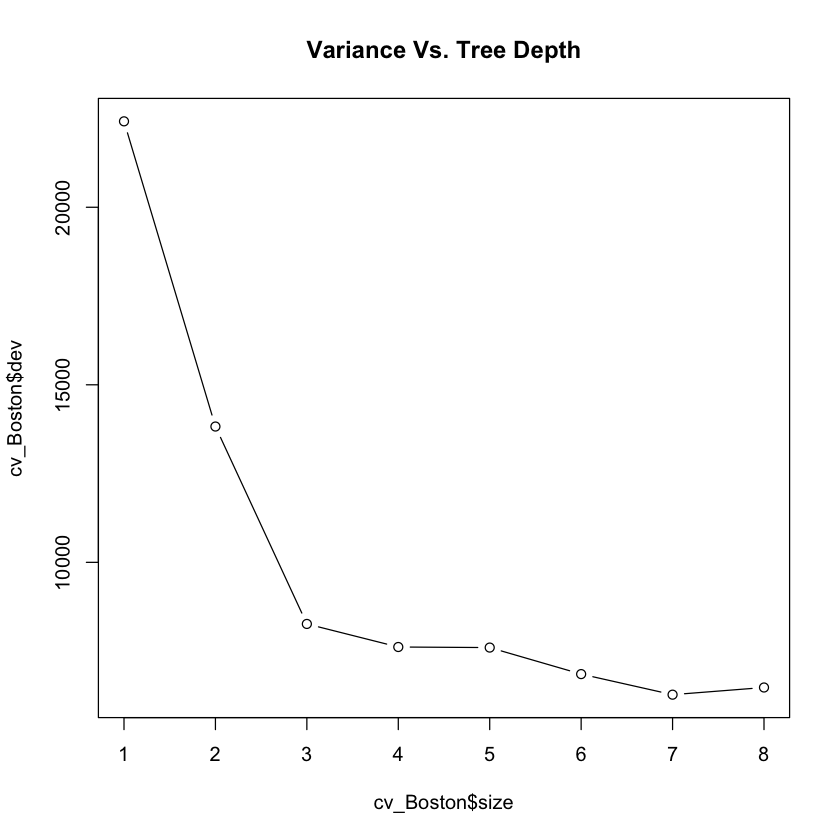

In [19]:
set.seed(1)
cv_Boston <- cv.tree(tree2_)
plot(cv_Boston$size, cv_Boston$dev, typ='b')
title('Variance Vs. Tree Depth')

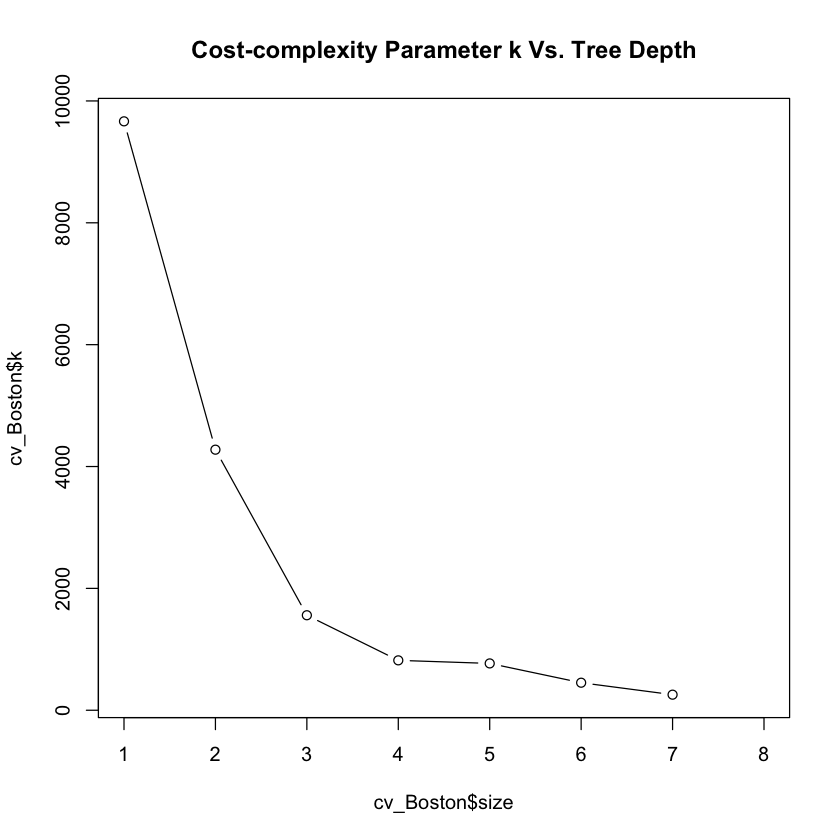

In [20]:
plot(cv_Boston$size, cv_Boston$k, typ='b')
title('Cost-complexity Parameter k Vs. Tree Depth')

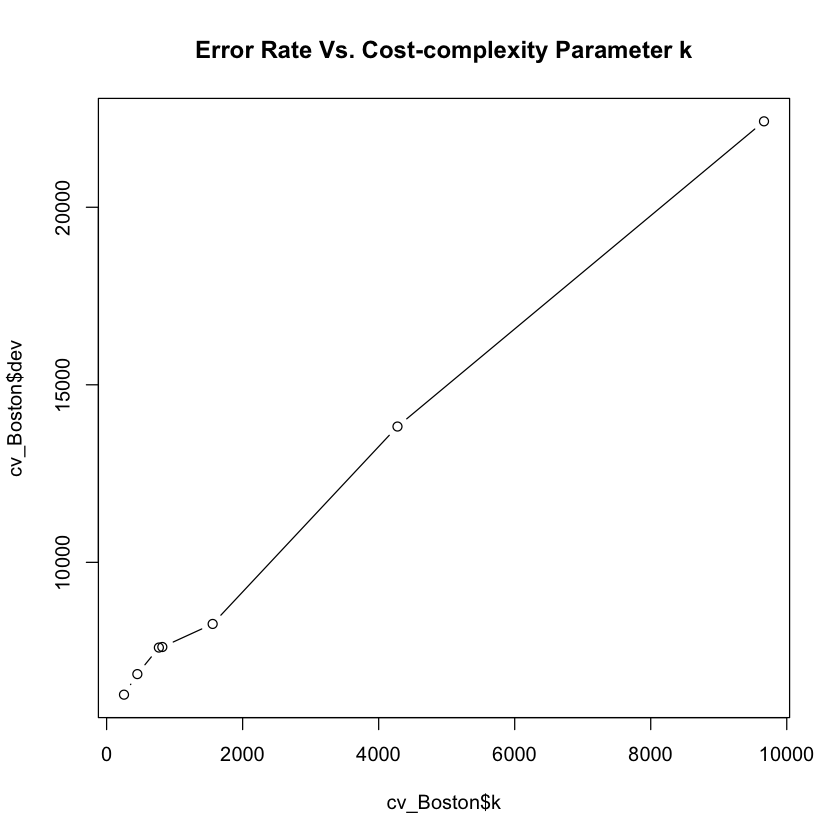

In [21]:
plot(cv_Boston$k, cv_Boston$dev, typ='b')
title('Error Rate Vs. Cost-complexity Parameter k')

help(cv.tree)

From the plots above, we can clearly see that there is a bias-variance tradeoff to be considered - a tree of depth 7 appears to be only marginally better than of depth 4. This clue may lead us to want to try to prune the regression tree.

The value $k$ corresponds to $\alpha$ in $\text{Equation 8.4}$

## Pruning a Regression Tree

Now let's use the `prune.tree` function to prune the regression tree back to the most important model features.

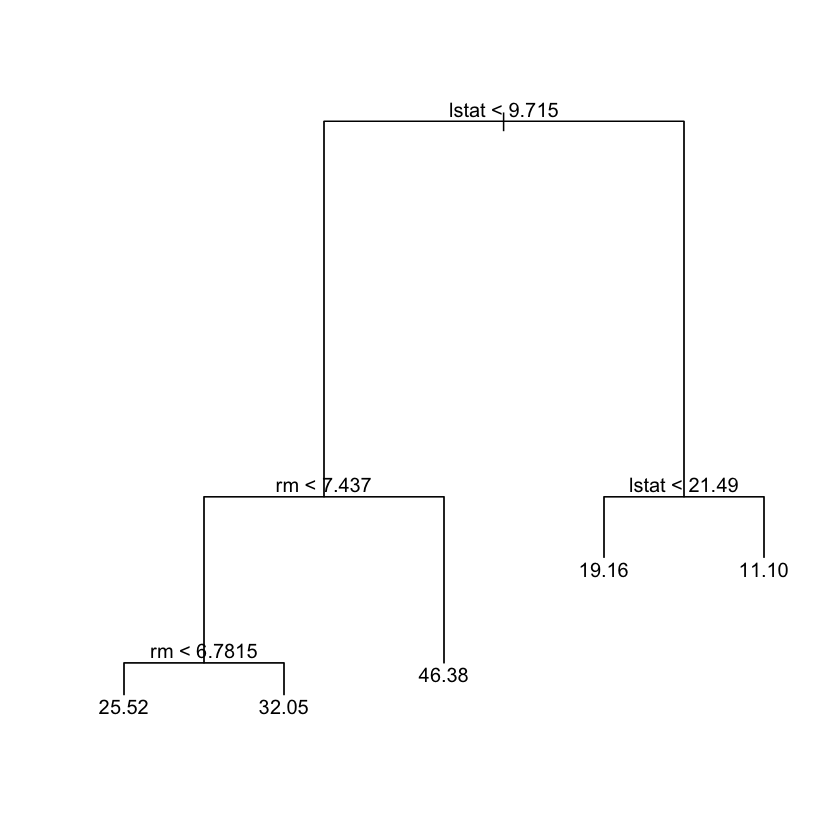

In [22]:
pruned_Boston_rt <- prune.tree(tree2_, best=5)
plot(pruned_Boston_rt)
text(pruned_Boston_rt, pretty = 0)

Once again, we can see from the tree above that the most important features for predicting the median value of owner occupied homes are
* `lstat`: *the lower status of the population (expressed in %)*
* `rm`: *average number of rooms per dwelling*

## Making Predictions

When it comes time to make predictions, we always use the unpruned tree to make predictions on the test data set.

If we are doing a classification task, set parameter `type="class"` within the call to the `predict` function.

help(predict)

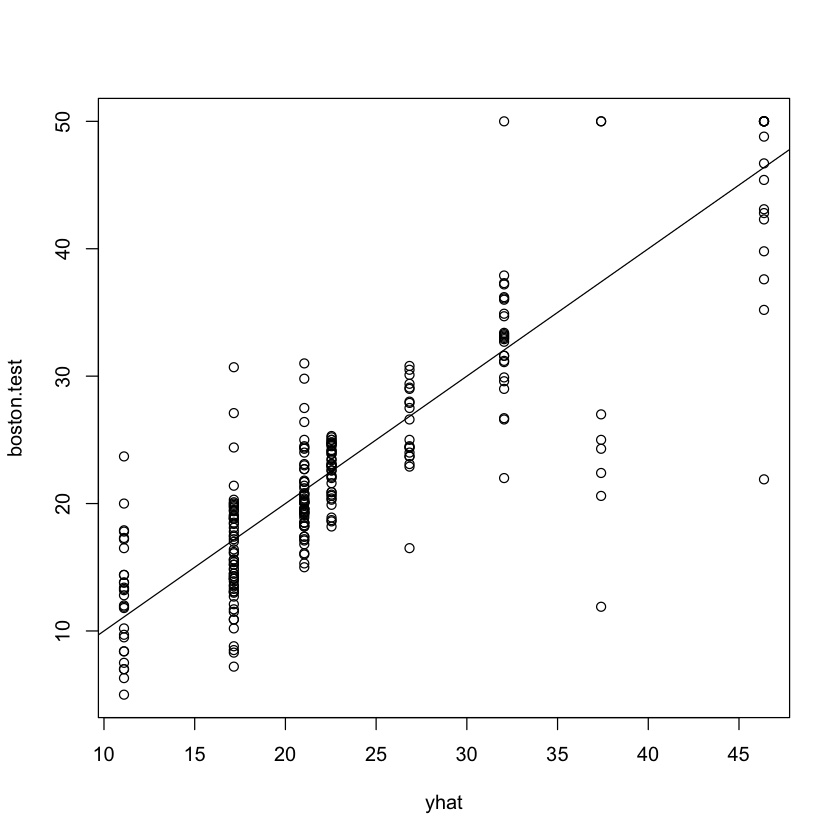

In [24]:
yhat=predict(tree2_, newdata=Boston[-train,])
boston.test=Boston[-train ,"medv"]
plot(yhat,boston.test)
abline(0,1)

### Mean Squared Error

We can calculate the model MSE literally:

In [25]:
mse <- mean((yhat - boston.test)^2)
mse

[1] 25.04559

Taking it one step further, we can use the square root of the mean squared error to back the statement that we are capable of making predictions within plus-or-minus x with a% accuracy.

In [26]:
sqrt(mse)

[1] 5.004557

In our example, we can say that we are capable of predicting the median `medv` within $\pm$ $5k precision.

## Classification Trees

Classification trees are very similar to regression trees. Our algorithm still uses recursive binary split, but changes because the predicted response for an observation is to put it in the most commonly occurring class of training observations in the region to which that observation belongs. Because our target variable is qualitative instead of quantitative, we must use a different error measure other than SSE as criterion for making splits.

**Classification error rate** is the criterion we use for making splits in our classification trees and is defined as the fraction of the training observations in a region that do not belong to that region's most common class:

$$
E = 1 - \underset{k}{\text{max}} \: \, \hat{p}_{mk}
$$

where $\hat{p}_{mk}$ represents the proportion of training observations in region $m$ that belong to class $k$.

However, the classification error is not sufficiently sensitive to the process of growing a tree. We need other measures:

### The Gini Index

* **Gini Index** is a measure of the total variance across all the $K$ classes (in the $m$th region) defined as:

$$
G = \sum^{K}_{k=1} \hat{p}_{mk}\left(1 - \hat{p}_{mk}\right)
$$

* Gini Index has a very small value when all of the $\hat{p}_{mk}$s are close to 0 or 1.
    * Also referred to as a measure of **node purity**
* A small $G$ indicates that a node contains observations from a single class

### Entropy

$$
D = - \sum^{K}_{k=1} \hat{p}_{mk} log\left(\hat{p}_{mk}\right)
$$

* Since $0 \leq \hat{p}_{mk} \leq 1$, we get $0 \leq \hat{p}_{mk} \leq log\left(\hat{p}_{mk}\right)$

Thus entropy will have a very small value if all of the $\hat{p}_{mk}$'s are close to 0 or 1.
* Entropy will be close to 0 if the $m$th node is pure

We use either Gini Index or Entropy to evaluate the quality of a particular split when building a classification tree since they are very sensitive to purity compared to the classification error rate.

### Deviance

When we call `summary` on our classification tree, deviance is reported:

$$
-2 \sum_{m}\sum_{k} n_{mk}\text{log}\left(\hat{p}_{mk}\right)
$$

where $n_{mk}$ is the number of observations.
* A small deviance is a sign that the tree provided good fit to the training data
* Residual mean deviance reported is equal to the deviance divided by $n - \left|T_{0}\right|$

## Example 3: `ISLR::Carseats`

In our third example, we'll build a classification tree based on a discretized `Sales` variable. We'll discretize `Sales` using the criteria `ifelse(Sales <= 8, "No", "Yes")`.

In [27]:
attach(Carseats)

In [28]:
high <- ifelse(Sales <= 8, "No", "Yes")
Carseats <- data.frame(Carseats, high)

In [29]:
tree3 <- rpart(high~. - Sales, Carseats)
tree3_ <- tree(high~. - Sales, Carseats)

### Plot classification tree

cex 0.948   xlim c(0, 1)   ylim c(0, 1)


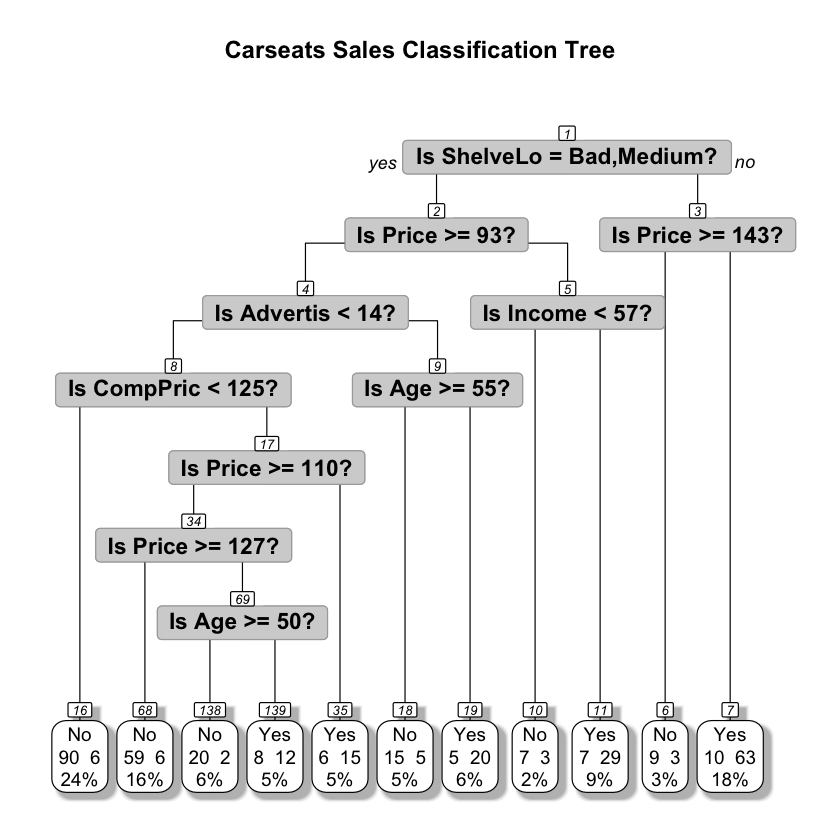

In [30]:
prp(tree3, main="Carseats Sales Classification Tree",
extra=101,
nn=TRUE, # display the node numbers
fallen.leaves=TRUE, # put the leaves on the bottom of the page
shadow.col="gray", # shadows under the leaves
faclen=0, # faclen=0 to print full factor names
trace=1, # print the automatically calculated cex
split.cex=1.2, # make the split text larger than the node text
split.prefix="Is ", # put "is " before split text
split.suffix="?", # put "?" after split text
split.box.col="lightgray", # lightgray split boxes (default is white)
split.border.col="darkgray", # darkgray border on split boxes
split.round=.5) # round the split box corners a tad

### Classification Tree `summary`

In [31]:
summary(tree3_)


Classification tree:
tree(formula = high ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

In the `summary` call above,

$$
\text{Number of terminal nodes}:\left|T_{0}\right| = 27
$$

$$
\text{Residual mean deviance}:\frac{\text{deviance}}{n - \left|T_{0}\right|} = \frac{170.7}{400-27} = \frac{170.7}{373} = 0.4575
$$

$$
\text{Misclassification error rate}:\frac{\text{training error rate}}{n} = \frac{36}{400} = 0.09
$$

Both the `summary` call and the plot of the classification tree tell us that `ShelveLoc` and `Price` are the two most important features, followed by `Age` , `CompPrice` , `Advertising` , and finally `Income`.

### Examine Tree

We can also examine the tree directly:

In [32]:
tree3_

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

### Example 3 Making Predictions

Let's split the dataset into a training and test set to simulate making predictions using the classification tree.

In [33]:
set.seed(2)
train=sample(1:nrow(Carseats), 200)
Carseats.test=Carseats[-train,]
High.test=high[-train]  # actual High values on the observations in the test set

In [34]:
tree.carseats=tree(high ~ . - Sales, data = Carseats, subset=train)
tree.pred=predict(tree.carseats, Carseats.test,type="class")
table(tree.pred,High.test)

         High.test
tree.pred No Yes
      No  86  27
      Yes 30  57

So our model accuracy is:

In [35]:
(86+57)/200

[1] 0.715

### Prune Tree to Improve Prediction Accuracy

Let's prune the tree to see if we can get better prediction results. We can set the parameter `FUN=prune.misclass` in our call to the `cv.tree` function.

This method uses the test set misclassification rate to guide the CV and pruning process.

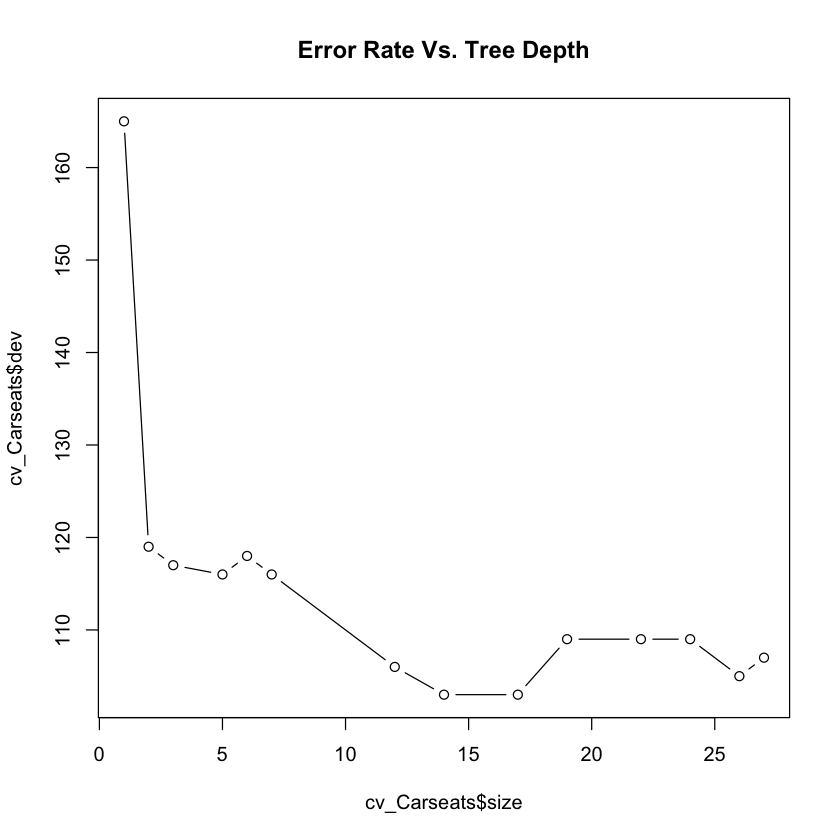

In [36]:
set.seed(3)
cv_Carseats <- cv.tree(tree3_, FUN=prune.misclass)
plot(cv_Carseats$size, cv_Carseats$dev, typ='b')
title('Error Rate Vs. Tree Depth')

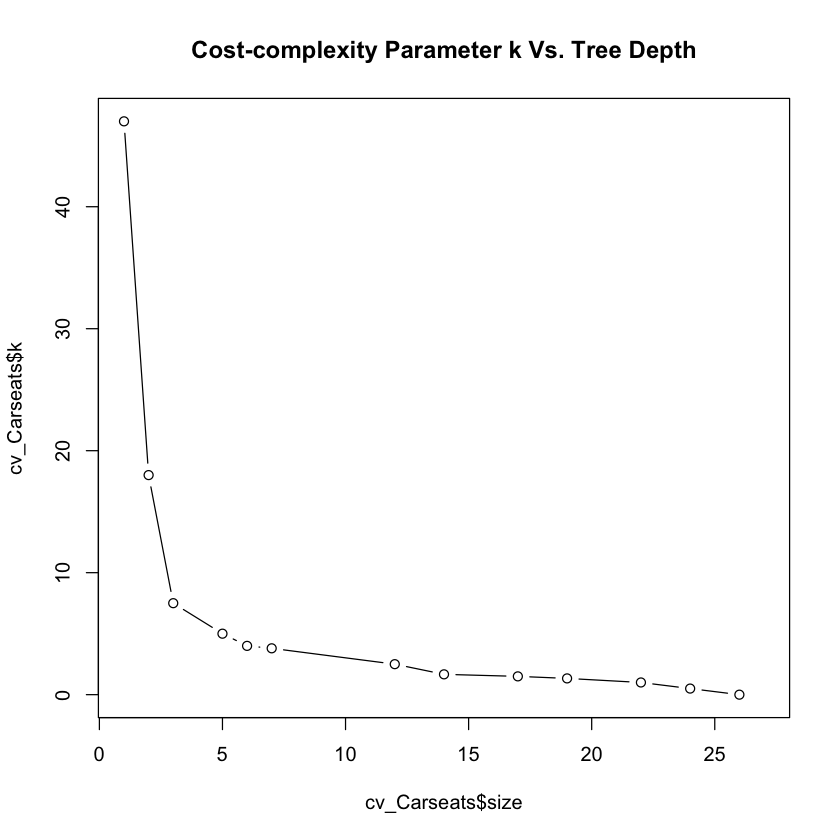

In [37]:
plot(cv_Carseats$size, cv_Carseats$k, typ='b')
title('Cost-complexity Parameter k Vs. Tree Depth')

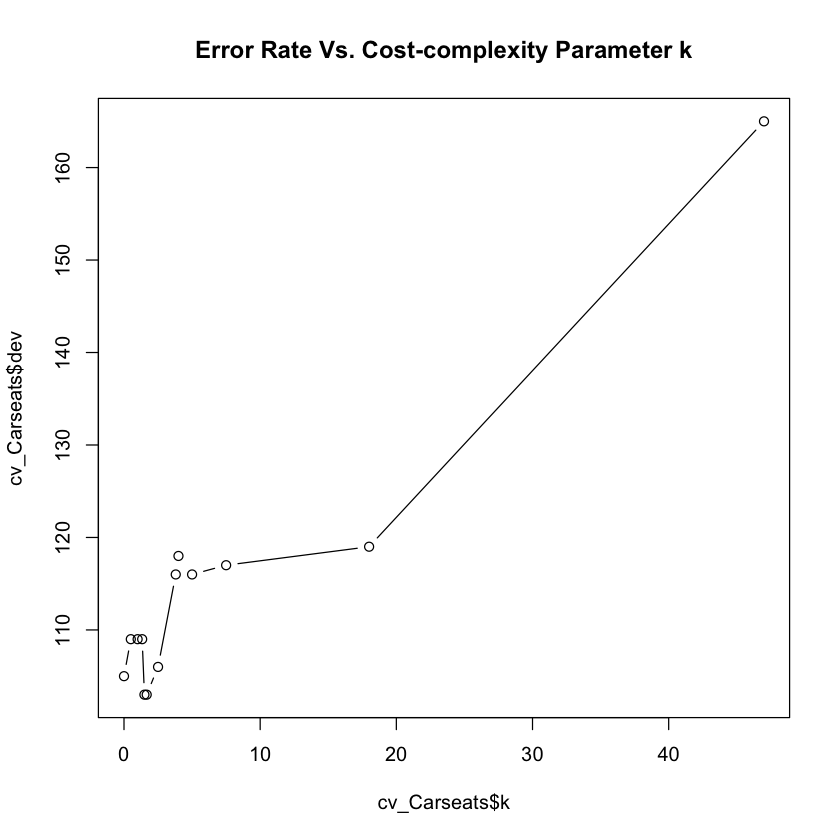

In [38]:
plot(cv_Carseats$k, cv_Carseats$dev, typ='b')
title('Error Rate Vs. Cost-complexity Parameter k')

Now that we've visualized the trade-offs between bias and variance, we can examine the pruned decision tree itself:

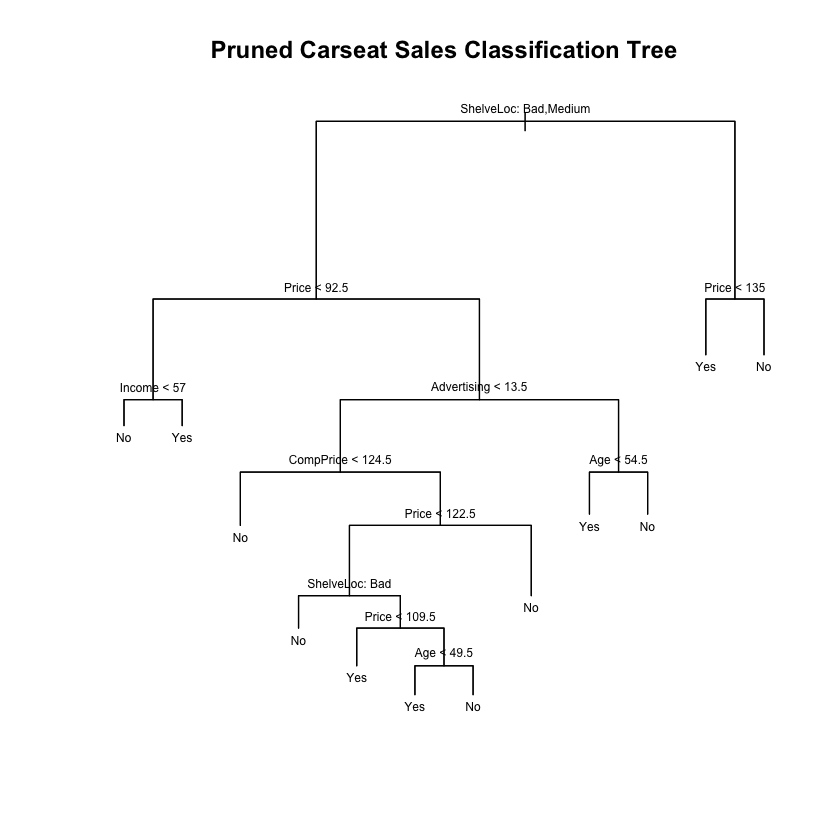

In [39]:
pruned_Carseats <- prune.misclass(tree3_, best=9)
plot(pruned_Carseats)
text(pruned_Carseats, pretty=0, cex=0.6)
title('Pruned Carseat Sales Classification Tree')

From here, we can mess with the number of prunes that we would like to perform using the `best` paramater in our call to the `prune.misclass` function. It all depends on what is important to us in our considerations of the bias-variance tradeoff.

## Bagging

When we use decision trees for prediction, they could suffer from **high variance**. If we split the training data into two parts at random, and fit a decision tree to both halves, the results could be quite different.
* A model with low variance is attractive because it will yield similar results if applied repeatedly to distinct data sets
    * Linear regression models tend to have low variance if $n>>p$
    
***Bootstrapping*** or bagging aggregation is a general-purpose technique for reducing the variance of a statistical learning method - very useful when using decision trees.

If we are given a set of independent observations $Z_{1}, \ldots , Z_{n}$ each with variance $\sigma^{2}$, the variance of the mean $\bar{Z}$ of these observations is equal to:

$$\text{variance} = \frac{\sigma^{2}}{n}$$

* Averaging a set of observations reduces variance

So this technique reduces variance (thus increasing prediction accuracy) by:
* take many training sets from the population
* build a seperate model using each training set
* average the resulting predictions

In math,

* Calculate $B$ predicted values $f^{1}(x), f^{2}(x), \ldots, f^{B}(x)$ using $B$ seperate training sets

* Average them to get a single low-variance model:

$$
\hat{f}_{avg}(x) = \frac{1}{B}\sum^{B}_{b=1} \hat{f^{b}}(x)
$$

In practice this isn't possible because we mostly do not have multiple training sets. Enter bagging and bootstrapping...

* Take repeated random samples ***with*** replacement from a single training data set
* Generate $B$ different bootstrapped training sets
* Learning method is trained on the $b$th bootstrapped training set to obtain the prediction $\hat{f^{*b}}(x)$
* Average all $B$ predictions to get:

$$
\hat{f}_{bag} = \frac{1}{B}\sum^{B}_{b=1} \hat{f^{*b}}(x)
$$

This technique is called ***bagging***. When implemented in code, bagging techniques grow trees in parallel, lending themselves very nicely for cluster or cloud implementations like Spark.

### Bagging and Regression Trees

For regression trees, the bagging procedure works by

1. Building $B$ regression trees using $B$ bootstrapped training sets
2. Predictions of these $B$ regression trees are then averaged
3. Trees are grown deep and not pruned - high variance, low bias
4. Averaging the predictions of these $B$ trees reduces variance

Bagging has been shown to give impressive accuracy improvements by combining together hundreds or thousands of trees into one model.

### Bagging and Classification Trees

The easiest way to apply bagging to classification trees is, for each test observation,
* Record the class predicted by each of the $B$ trees for that observation
* Take a majority vote

The majority vote is the overall prediction of the most commonly occuring class (mode) among all $B$ predictions for that test observation.

### Out-of-Bag Estimation

To estimate the test error of a bagged model, there is a straightforward way without using cross-validation or validation set approach called ***Out-of-Bag*** (OOB) estimation.

When performing bagging, trees are repeatedly fit to bootstrapped subsets of the observations. It can be shown that, on average, each bagged tree makes use of around 2/3 of the observations. The other 1/3 of the observations that are not used to fit a given bagged tree are called OOB observations.

* We can predict the response for the $i$th observation using each of the trees in which that observation was OOB
    * This yields around $B$/3 predictions for that *i*th observation

To obtain a single OOB prediction for the $i$th observation, we can average the predicted responses (if task is regression) or take a majority vote (for classification task).

* Repeat for all *n* observations and then compute the overall OOB error rate (MSE for regression, accuracy/precision for classification)
* Resulting OOB error is a valid estimation of the test error for the bagged model since the $i$th observation being used for test was not used by the tree during training [proof](https://www.stat.berkeley.edu/~breiman/OOBestimation.pdf)
* It can be shown that with $B$ sufficiently large, OOB error is virtually similar to LOOCV
    * The OOB approach is very convenient for bagging on large datasets where cross-validation would be computationally infeasible
    
### Bagging and Variable Importance Measures

Although bagging improves our model's predictive capability, it comes at the cost of model interpretability. This is because it becomes impossible to represent the model using a single tree once we aggregate the predictions. However, we can still obtain an overall summary of variable importance:

* Use SSE for regression trees
    * Record the total amount of SSE reduction due to splits over a given feature, averaged over all $B$ trees
        * A large average value indicates an important feature
* Gini Index for classification trees
    * When bagging classification trees, add the total amount of Gini Index reduction sue to splits over a given feature, averaged over all $B$ trees

[Caveats](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1796903/pdf/1471-2105-8-25.pdf) to using random forests for feature selection.

## Random Forests

Random Forests are an improvement over bagged trees by way of a small tweak that **decorrelates** the trees. Similar to bagging, we build a number of trees on bootstrapped training samples.
* But in random forests, when building the decision trees, each time a split is considered, a **random sample of $m$ predictors** is chosen from the full set of $p$ predictors
* The split is allowed to use only one one predictor from the $m$ randomly selected predictors
    * A fresh sample of $m$ predictors is used at each split, typically $m \approx \sqrt{p}$
    
Notice how the random forest algorithm is not allowed to consider a majority of the $p$ predictors? For good reason:

Assume there is one very strong predictor in the data along with a number of other moderately strong predictors. 
* Then in the collection of bagged trees, most or all of the trees will use the strong predictor as the root node
    * All of the bagged trees will look similar to each other and thus their predictions will be highly correlated

We know that averaging many highly correlated quantities does not lead to as large a reduction in variance compared to averaging many uncorrelated quantites, so we try to keep things as uncorrelated as possible.

Random Forests overcome the correlation problem by forcing each split to only consider a subset (typically $m \approx \sqrt{p}$) of the $p$ predictors.

Therefore, on average $\frac{(p-m)}{p}$ of the splits won't even consider the strongest predictor, thereby letting the other predictors have more of a chance.
* Analog to ***decorrelating*** the trees, thus decreasing variance amongst the trees
* If $m=p$, then bagging is a special case of random forests

## Boosting

***Boosting*** is another way to improve prediction results of regression and classification trees.

Boosting grows trees sequentially from previously grown trees but focuses more on modeling the misclassifications from the previously grown tree.
* Involves combining a large number of decision trees, $\hat{f^{1}}, \ldots , \hat{f^{B}}$

### Boosting for Regression Trees

Boosting for regression trees work in the following way:
* Fit one regression tree to all of the predictor space
* Given the current regression tree model, we fit a decision tree to the ***residuals*** from that model, NOT the outcome
* The new decision tree is added into the fitted function in order to update the residuals
    * Each decision tree can be rather small, with only a few leaves, determined by the (interaction depth) parameter $d$ in the algorithm
    
* By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well
* Shrinkage parameter $\lambda$ slows the process even further, allowing more trees and differently shaped trees to hack away at the residuals.

In math,

1. Set $\hat{f}(x)=0$ and $r_{i} = y_{i}$ for all $i$ in the training data set
2. For $b=1,2,\ldots,B$, repeat:
    * Fit a tree $\hat{f^{b}}$ with $d$ splits (so it will have $d+1$ terminal nodes) to the training data $\left(X,r\right)$
    * Update $\hat{f}$ by adding in a shrunken version of the new tree: $$\hat{f}(x) \leftarrow \hat{f}(x) + \lambda \hat{f^{b}}(x)$$
    * Update the residuals: $$r_{i} \leftarrow r_{i} - \lambda \hat{f^{b}}(x_{i})$$
3. Output the boosted model: $$\hat{f}(x) = \sum^{B}_{b=1}\lambda \hat{f^{b}}(x)$$

### Boosting for Classification Trees

This topic was omited from the ISLR textbook, but is detailed in the following papers:

https://link.springer.com/content/pdf/10.1023/A:1007515423169.pdf

http://www.jmlr.org/papers/volume8/mease07a/mease07a.pdf

### Boosting's Three Tuning Parameters

1. The number of trees $B$
    * If $B$ is too large, it could result in overfitting in boosting
    * Cross-validation is used to select $B$
2. $\lambda$, the skrinkage parameter
    * A small positive number like 0.01 or 0.001
    * Very small $\lambda$ can require using a large value of $B$ to get good prediction performance
3. The number of splits $d$, which controls the complexity of the boosted ensemble.
    * $d=1$ works well - each tree has a single split and is referred to as a **stump**
    * This boosted ensemble is fitting an additive model since each term involves a single variable
    * More generally, $d$ is the interaction depth and controls the interaction order of the boosted model, since $d$ splits involve at most $d$ variables
    
Smaller trees reduce overfitting.

## Bagging, Random Forests, and Boosting

Let's apply everything to the `MASS::Boston` dataset using the `randomForest` R package.

In [41]:
if (!require(randomForest)) install.packages("randomForest")
library(randomForest)
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston)/2)
y_test <- Boston[-train, "medv"]
bagged_Boston_model <- randomForest(medv~.,
                                    data=Boston,
                                    subset=train,
                                    mtry=13,
                                    importance=TRUE)
bagged_Boston_model


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.08966
                    % Var explained: 86.57

### Bagging Performance on Test Test

Now let's make predictions and grade our model performance based on the test error rate.

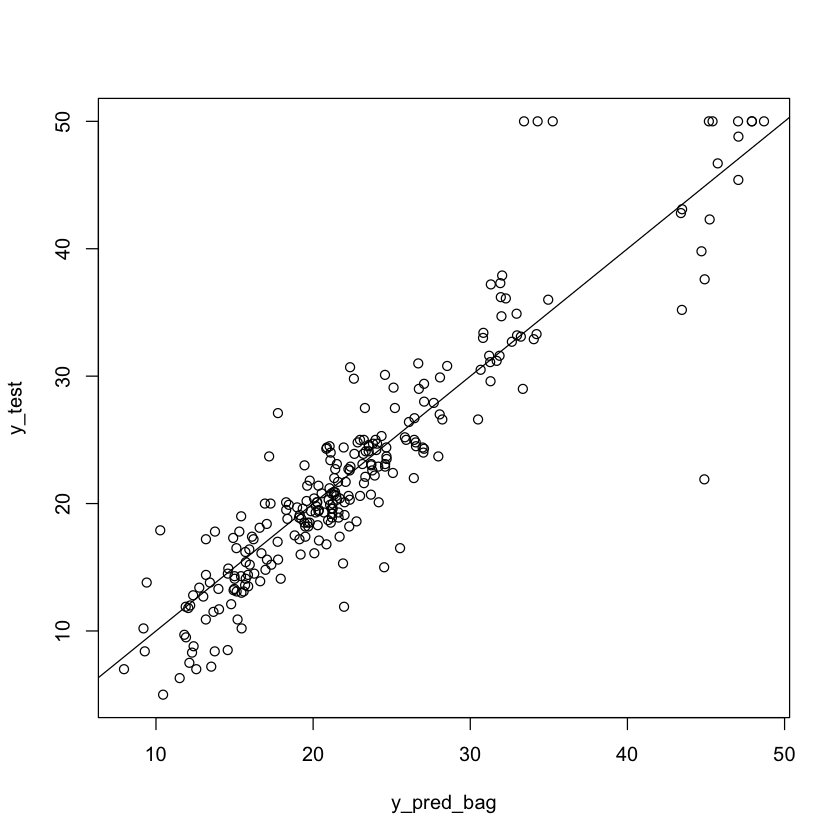

In [42]:
y_pred_bag <- predict(bagged_Boston_model,
                    Boston[-train, ])
plot(y_pred_bag, y_test)
abline(0,1)

In [43]:
mean((y_pred_bag-y_test)^2)

[1] 13.33831

### Random Forest Performance on `MASS::Boston`

Let's compare the bagged model performance to that of a random forest.

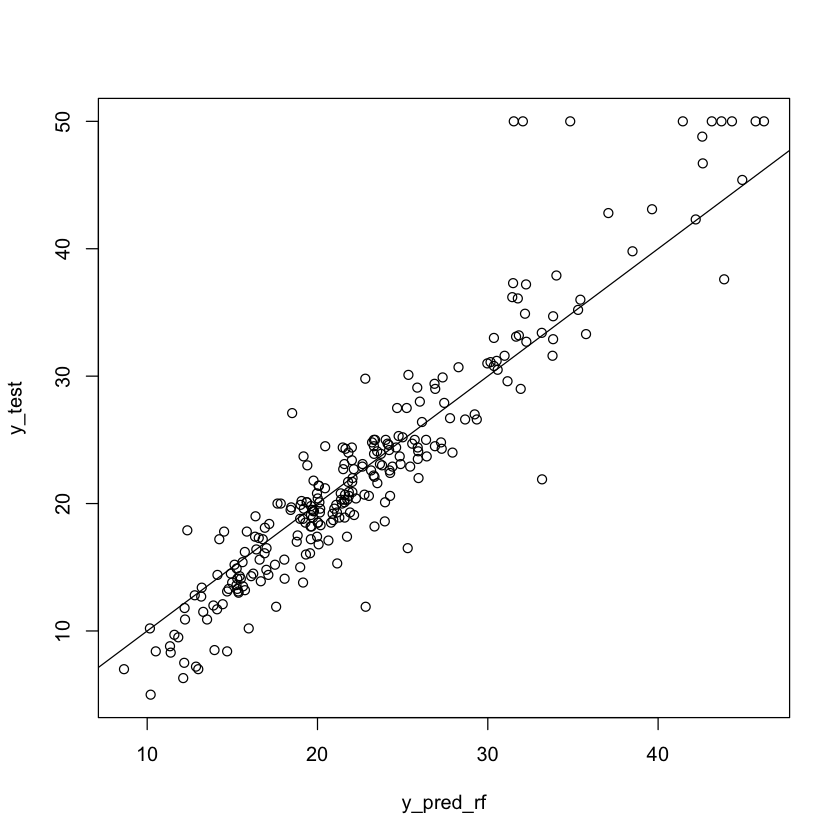

In [68]:
set.seed(1)
rf_Boston_model <- randomForest(medv~.,
                                    data=Boston,
                                    subset=train,
                                    mtry=4)
y_pred_rf <- predict(rf_Boston_model,
                    Boston[-train, ])
plot(y_pred_rf, y_test)
abline(0,1)

In [69]:
mean((y_pred_rf-y_test)^2)

[1] 11.93146

Our test set MSE is better using the Random Forest in this case.

### `importance()` function

Shows the total decrease in node impurity that results from splits over that variable, averaged over all trees.
* Regression trees use training SSE to determine node impurity
* Classification trees use training deviance to determine impurity

In [70]:
importance(rf_Boston_model, type=2)

,IncNodePurity
crim,1303.9189
zn,114.0047
indus,1309.5213
chas,108.5740
nox,1310.5029
rm,5481.3672
age,690.2379
dis,1463.2625
rad,183.6832
tax,714.5192


### `varImpPlot()` function

Typically, it makes more sense to plot the variable importance using a variable importance plot function `varImpPlot`

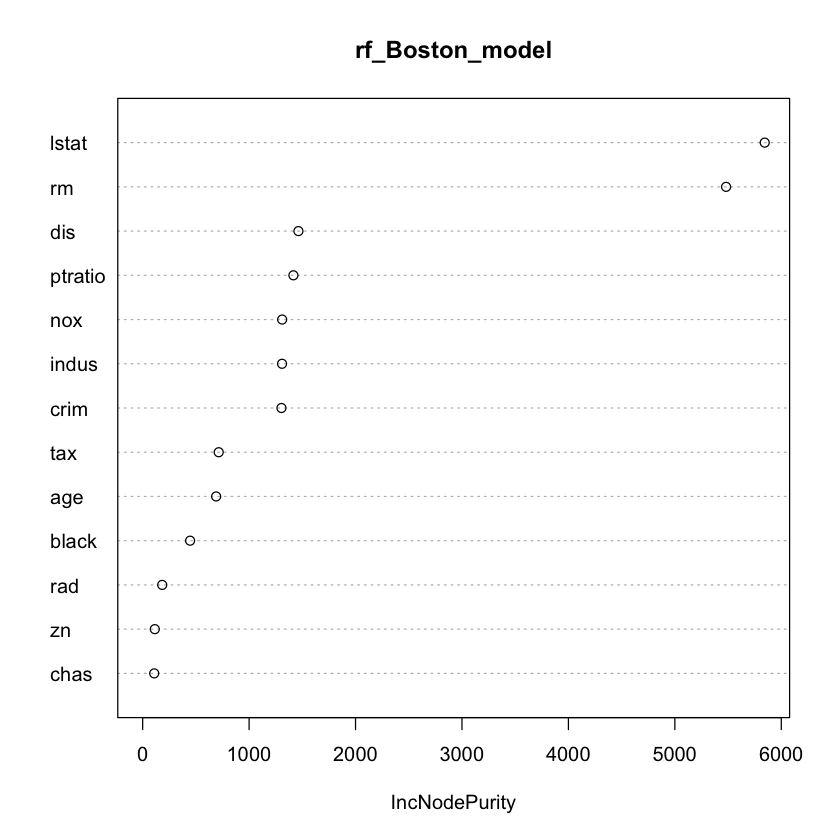

In [71]:
varImpPlot(rf_Boston_model)

Across all of our regression trees, the two most important variables are:
* `rm` - average number of rooms per dwelling
* `lstat` - wealth level of the community as measured by the lower status percentage of the population

## Boosting on `MASS::Boston` Dataset

We use the `gbm` package and its `gbm()` function to fit boosted regression trees to the Boston dataset.

* Run `gbm()` with the parameter `distribution="gaussian` since this is a regression problem
* If it were classification then the parameter would be `distribution="bernoulli"`
* Set the parameter `n.trees=5000`
* Set the parameter `interaction.depth=4` to limit the depth of each tree

In [73]:
if (!require(gbm)) install.packages("gbm")
library(gbm)

,var,rel.inf
lstat,lstat,37.0661275
rm,rm,25.3533123
dis,dis,11.7903016
crim,crim,8.0388750
black,black,4.2531659
nox,nox,3.5058570
age,age,3.4868724
ptratio,ptratio,2.2500385
indus,indus,1.7725070
tax,tax,1.1836592


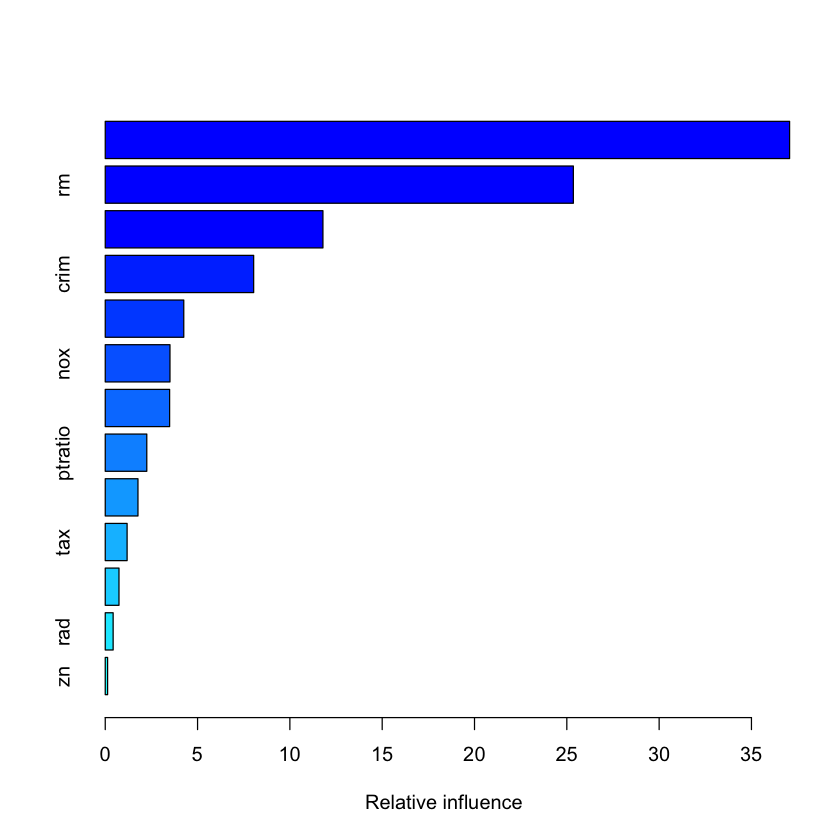

In [78]:
set.seed(1)
boost_Boston_model <- gbm(medv~.,
                                data=Boston[train,],
                                distribution="gaussian",
                                n.trees=5000,
                                interaction.depth=4)
summary(boost_Boston_model)

Once again, `lstat` and `rm` are the most important variables. We can also produce partial dependence plots for these two variables.

### Partial Dependence Plots

Produce the marginal effect of the selected variables on the response after integrating out the other variables.

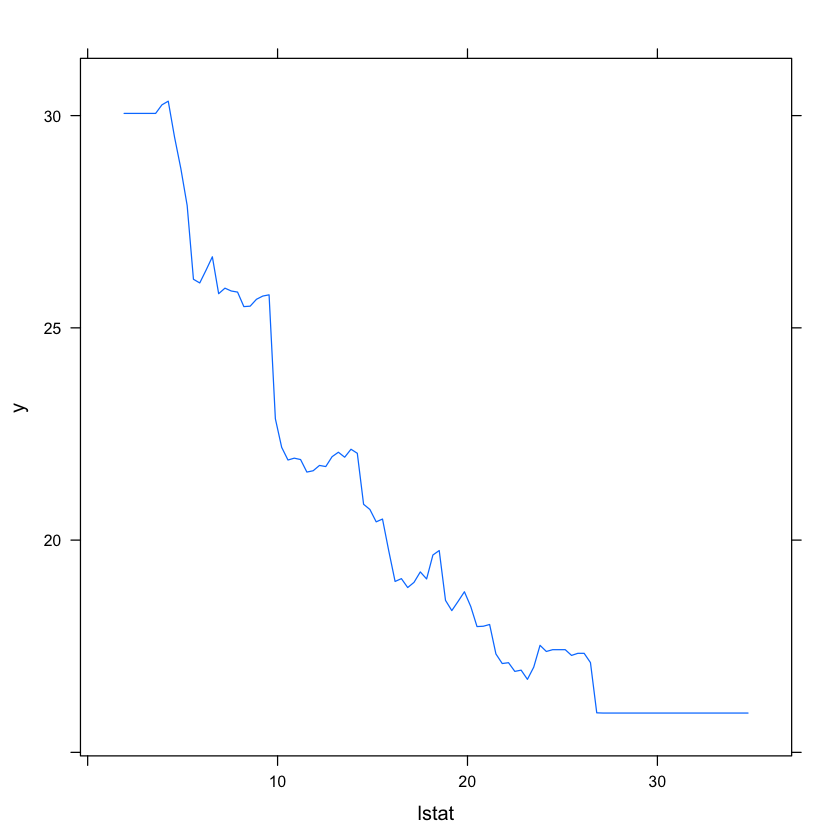

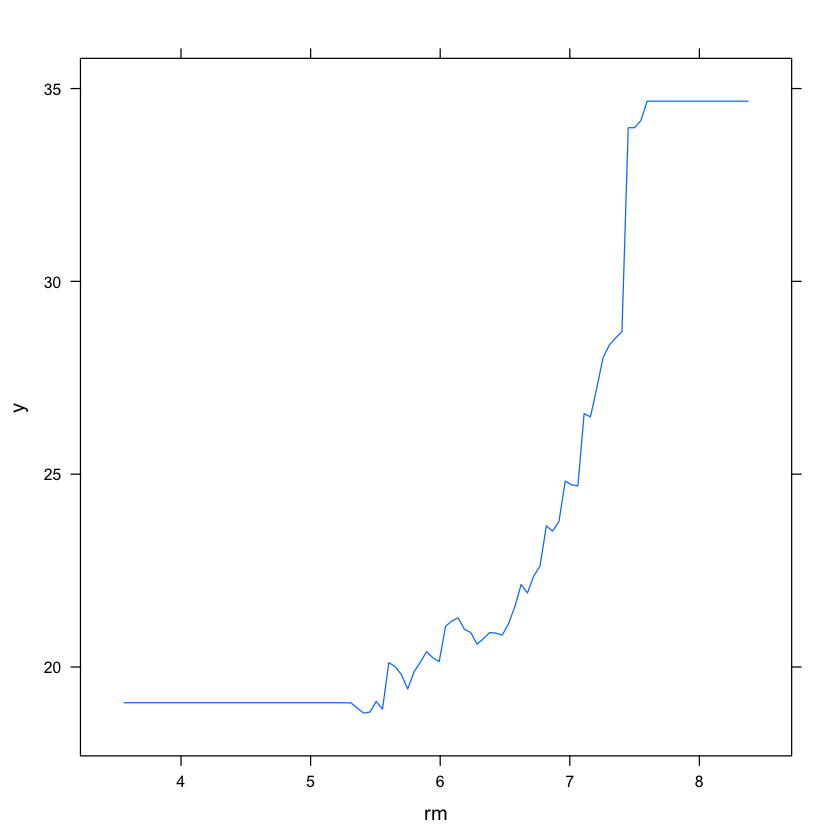

In [79]:
par(mfrow=c(1,2))
plot(boost_Boston_model, i="lstat")
plot(boost_Boston_model, i="rm")

The partial dependence plots above show us that the median house prices are increasing with `rm` and decreasing with `lstat` which intuitively should make sense. 

We can make predictions and evaluate the boosted model to bagging and random forest models.

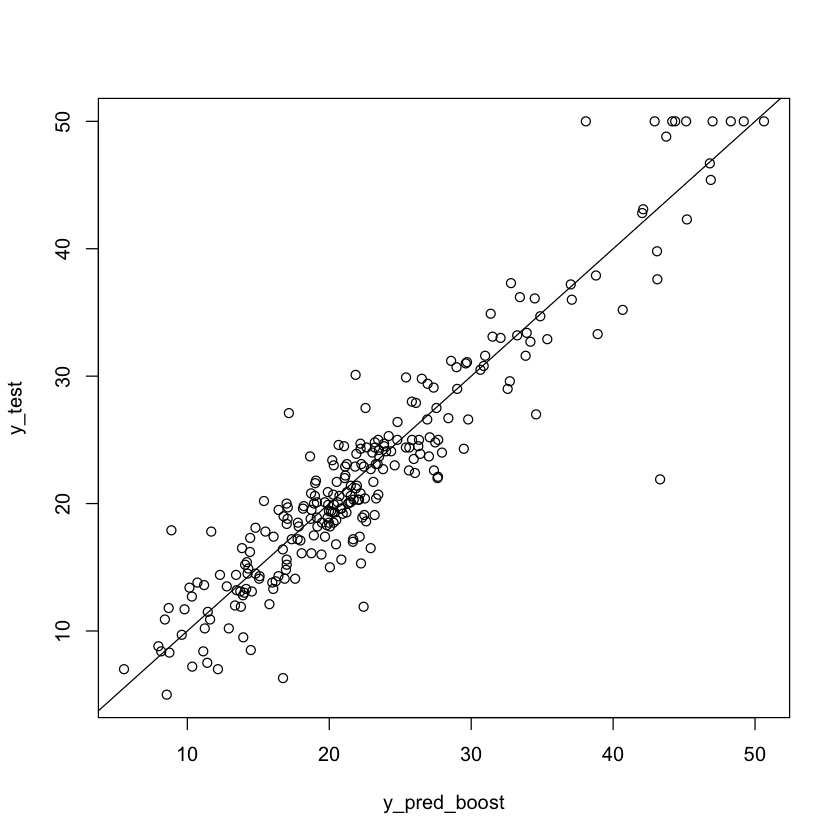

In [91]:
y_pred_boost <- predict(boost_Boston_model,
                    Boston[-train, ], n.trees=5000)
plot(y_pred_boost, y_test)
abline(0,1)

In [92]:
mean((y_pred_boost-y_test)^2)

[1] 10.81479

### `shrinkage` parameter in `gbm` function

The boosted models performance is similar to that of the random forest. We can always experiment with the shrinkage parameter and see the effects on our test MSE (grid search is a good option).

,var,rel.inf
lstat,lstat,38.8138515
rm,rm,26.0780285
dis,dis,10.2857193
crim,crim,6.2221516
black,black,4.4828621
age,age,3.8833748
nox,nox,3.5624316
ptratio,ptratio,2.6779832
tax,tax,1.6409549
indus,indus,1.2494299


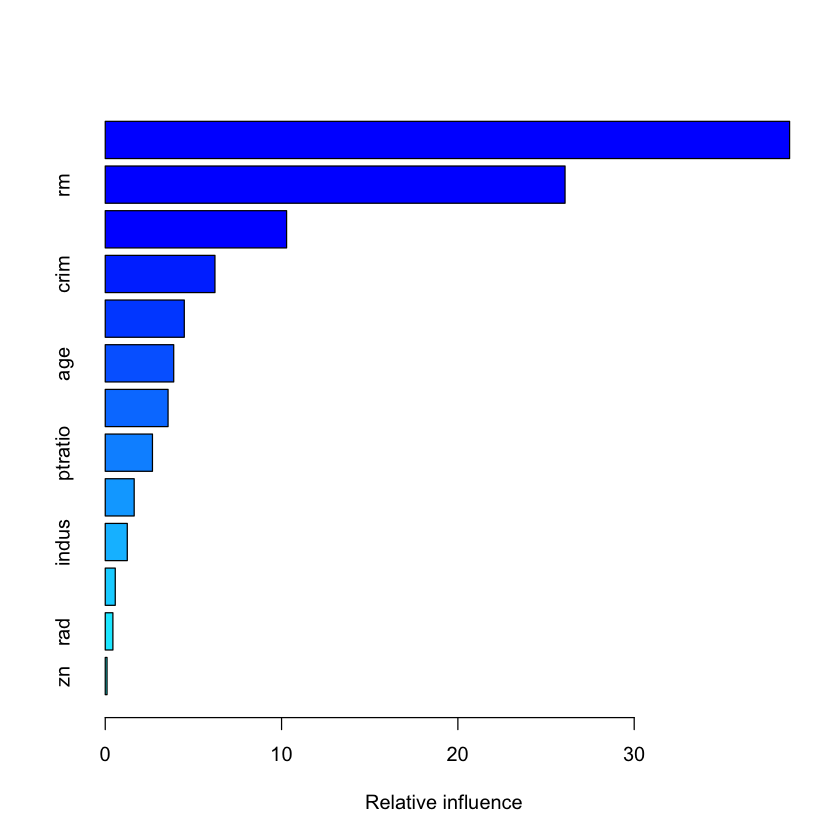

In [93]:
set.seed(1)
boost_Boston_model2 <- gbm(medv~.,
                                data=Boston[train,],
                                distribution="gaussian",
                                n.trees=5000,
                                interaction.depth=4,
                                shrinkage = 0.02)
summary(boost_Boston_model2)

In [95]:
y_pred_boost2 <- predict(boost_Boston_model2,
                    Boston[-train, ], n.trees=5000)
mean((y_pred_boost2-y_test)^2)

[1] 10.06274

# Fin!

That wraps up this notebook. For further details check out ISLR Chapter 8 and the papers linked above. I've also implemented all of the concepts in this notebook into a vanilla python [implementation](http://github.com/tjefferies/Masters/tree/master/Random%20Forest%20From%20Scratch) of random forest only using numpy.